In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import os, subprocess, glob, re, gzip, math, shutil, itertools, sys, time, math, string
from shutil import copyfile
from numpy import *
from numpy import linalg
sys.path.append('/home/linnaan/lib/')
from libSlurm import make_submit_file
from libSlurm import make_dist_plots
sys.path.append('/home/norn/NTF2/210429_MLD_vs_hom/scripts')
import jupyter_utils
import pickle
import pandas as pd
import design_utils
from sklearn.cluster import KMeans
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import IFrame

import importlib
importlib.reload(design_utils)

<module 'design_utils' from '/home/norn/NTF2/210429_MLD_vs_hom/scripts/design_utils.py'>

In [11]:
df = pd.read_csv('design_peptide_counts.csv')
df = df[df['candidate_peptides']>=2]
# for j,(i,row) in enumerate(df.iterrows()):
#     f = row['pdb_file']
#     shutil.copy(f, f'pdbs/c2g_{j}.pdb')
#     df.at[i,'shortName'] = f'c2g_{j}.pdb'


In [27]:
input_csv = 'design_peptide_counts_for_order.csv'
df = df[['design','design_length','shortName']].rename(columns={'design':'seq','design_length':'length'})

df.to_csv(input_csv)

# Prepare samples for chip order
> 1. This notebook prepared for samples which require 2-piece assembly
2. Material: all pdbs for order
3. Rough Steps:
    1. pdbs will be translated into amino acid sequences
    2. aa sequences will be sorted into different subpools (1000 sequence each) based on length
    3. Within each subpool, sequences will be pad to the same length
    4. Each subpool will be translated to DNA sequences
    5. Each translated subpool will be added with required adaptors
    6. Each prepared subpool will be measured for its overlap diversity

In [28]:
%pwd

'/mnt/home/norn/ligands/c2a/order'

In [29]:
PARENT_DIR = '/mnt/home/norn/ligands/c2a/order'
input_df = input_csv

In [30]:
os.chdir(PARENT_DIR)
%pwd

'/mnt/home/norn/ligands/c2a/order'

In [33]:
df = pd.read_csv(input_df)[['shortName','seq','length']].rename(columns={'shortName':'design'})
df.head()

,design,seq,length
0,c2g_0.pdb,SEFLRVSLELVKIALRRGDPRLVYELVAIAVYLAQLEGDREVLKEL...,165
1,c2g_1.pdb,DVAEILYLVAQAYLRGDPDLLKRLLELILRLIKEALERGDLEQLIK...,159
2,c2g_2.pdb,DLEEQLKRALEEGDLLLVFLLAFFILKLLLLEGDPEKLREILEILL...,160
3,c2g_3.pdb,DLEELIKLLLEARKKGDLLFLVFTLIMLLQAALIRGDEETLKFVLK...,163
4,c2g_4.pdb,DEEYLRFLLKAVEEAIRRGDPDTALFLVFLAIFIAIKIGDPEALKK...,165


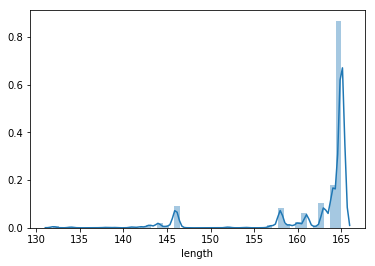

In [35]:
#remove duplicate
assert len(df) == len(df.drop_duplicates(subset='seq'))
# display(df[df.duplicated(subset='seq')])
sns.distplot(df['length'])

### Split to different subpools

You have 3243 designs


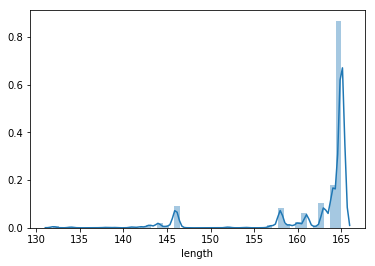

In [36]:
# change order based on length
df = df.sort_values(by='length',ascending=True)

#check aa length distribution
sns.distplot(df['length'])

print(f'You have {len(df)} designs')

### decide subpools based on total length and legth distribution
- each subpool (aka oligos with the same adaptors) should less than 1000 oligos. To many oligos will decrease assembly effciency.
- the smaller each pool, the better, but don't do too small, since it will take long time PCR to enrich your libraries.

In [40]:
# MISC functions
def merge_length(df_in):
    '''
    pad all sequences in each subpool to the same length as the max of the design in that subpool
    '''
    df_out = pd.DataFrame(columns=df_in.columns)
    linker = 'GSSGGSSGGSSG'
    min_length,max_length = list(df_in['length'])[0],list(df_in['length'])[-1]
    for num,pdb in enumerate(list(df_in['design'])):
        length = df_in.loc[num].at['length']
        if length != max_length:
            orig_seq = df_in.loc[num].at['seq']
            q = int(max_length-length)
            new_seq = orig_seq + linker[0:q]
            df_in.iloc[num,df_in.columns.get_loc('seq')] = new_seq
            df_in.iloc[num,df_in.columns.get_loc('length')] = len(new_seq)
    return df_in


# Decide subpool split and pad to longest sequence in each subpool
df_list = []
subpool_list = [810]*3+[813] #input the number you want in each subpool
assert np.sum(subpool_list) == len(df)

start = 0
for num,pool_size in enumerate(subpool_list):
    if num < 100:
        end = start + pool_size
        print('--------process seq %s ~ %s ------'%(start,end))
        df_subpool = pd.DataFrame(columns=df.columns)
        df_subpool = df_subpool.append(df.iloc[start:end])
        print('subpool size: %d'%len(df_subpool))
        min_length,max_length = list(df_subpool['length'])[0],list(df_subpool['length'])[-1]
        print('Before padding: min %d max %d'%(min_length,max_length))
        df_subpool = df_subpool.reset_index()
        df_subpool = merge_length(df_subpool)
        df_subpool = df_subpool.sort_values(by='length',ascending=True)
        min_length,max_length = list(df_subpool['length'])[0],list(df_subpool['length'])[-1]
        print('after padding: min %d max %d'%(min_length,max_length))
        fp = open('./subpool_{}'.format(num),'w')
        fp.write('\n'.join('%s %s'%(df_subpool.iloc[num].at['design'],df_subpool.iloc[num].at['seq']) for num in range(len(df_subpool))))
        fp.close()
        start = end
df_subpool.tail()

--------process seq 0 ~ 810 ------
subpool size: 810
Before padding: min 132 max 163
after padding: min 144 max 163
--------process seq 810 ~ 1620 ------
subpool size: 810
Before padding: min 163 max 165
after padding: min 165 max 165
--------process seq 1620 ~ 2430 ------
subpool size: 810
Before padding: min 165 max 165
after padding: min 165 max 165
--------process seq 2430 ~ 3243 ------
subpool size: 813
Before padding: min 165 max 165
after padding: min 165 max 165


,index,design,seq,length
274,1760,c2g_1760.pdb,DKYEEMLQRLLEQAYKEGDYETLVKLLSLLATQAAEKGDPSLRETV...,165
275,1761,c2g_1761.pdb,SDNIVDQLEELLREARENGDKYTVVQLARILLQLAEEKGDPNKLKY...,165
276,1763,c2g_1763.pdb,SKELKKLEESVRKASERGDPKSVEQSVRAAVYYAARQGDRETLKRL...,165
266,1777,c2g_1777.pdb,DDDLKTLLELLQQTLEEGDPETALQVLRYAITRASQLGDEEVLKEL...,165
812,3242,c2g_3242.pdb,DEFLDELLKILEETLKKGDPYFALFVLLLAIILALLLGDERVLREL...,165


## Reverse transcribe
- Use the scripts from PPI

In [41]:
# Generate commands for DNAworks
for num,subpool in enumerate(glob.glob(PARENT_DIR + '/subpool_*')):
    print(subpool)
    if num < 100:
        reverse_translate_dir = subpool+'_reverse_translate'
        os.makedirs(reverse_translate_dir,exist_ok=True)
        os.chdir(reverse_translate_dir)
        result = subprocess.run(['python2','/home/longxing/bin/DNAWorks/1_reverse_translate.py','-seq_list',subpool], stdout=subprocess.PIPE)

/mnt/home/norn/ligands/c2a/order/subpool_0
/mnt/home/norn/ligands/c2a/order/subpool_3
/mnt/home/norn/ligands/c2a/order/subpool_1
/mnt/home/norn/ligands/c2a/order/subpool_2


In [42]:
# If you have many sequences, submit to digs
Submit = True
if Submit:
    for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
        if num < 100:
            os.chdir(subpool_dir)
            cmds_f = subpool_dir + '/dnaworks_commands_all.list'
            make_submit_file(cmds=cmds_f, submitfile=cmds_f + '.submit.sh', queue='long', group_size=10, logsfolder='logs', cpus=1, mem='1g', needs_gpu=False)
            subprocess.check_call('sbatch dnaworks_commands_all.list.submit.sh',shell=True)
            print('submitted %s'%subpool_dir)

submitted /mnt/home/norn/ligands/c2a/order/subpool_3_reverse_translate
submitted /mnt/home/norn/ligands/c2a/order/subpool_2_reverse_translate
submitted /mnt/home/norn/ligands/c2a/order/subpool_1_reverse_translate
submitted /mnt/home/norn/ligands/c2a/order/subpool_0_reverse_translate


- wait till jobs finish on digs
- Then collect all results

## Collect all reverse transcribed sequences

In [45]:
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    if num < 100:
        os.chdir(subpool_dir)
        result = subprocess.run(['python2', '/home/longxing/bin/DNAWorks/2_collect_dnaseq.py'], stdout=subprocess.PIPE)
        result2 = subprocess.run(['python', '/home/longxing/bin/DNAWorks/3_check_seq.py','DNA_sequence.list '], stdout=subprocess.PIPE)

- In each folder, `DNA_sequence.list` contains the sequence

## Prepare DNA sequence files into a file readable by OligoOverlapOpt

In [46]:
for num,subpool_dir in enumerate(glob.glob(PARENT_DIR + '/subpool_*_reverse_translate')):
    if num < 100:
        os.chdir(subpool_dir)
        DNA_list = []
        fp = open('./DNA_sequence.list','r')
        for line in fp:
            DNA_list.append(line.split()[1:])
        fp.close()
        fp = open(os.path.basename(subpool_dir).replace('_reverse_translate','_dna_seq'),'w')
        fp.write('\n'.join('\t'.join(item) for item in DNA_list))
        fp.close()

## Prepare oligo combs
- Make a list of all possible combs of all adaptors
- <font color=red> Don't run again unless new comb need to be added.</font>
- To add new comb, add sequence to `/home/linnaan/software/LA_OligoOverlapOpt/all_primers.txt`

In [47]:
# primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
# fp = open(primer_dir + '/all_primers.txt')
# all_primers = []
# for num,line in enumerate(fp):
#     all_primers.append([line.split()[0],line.split()[1],line.split()[-1].rstrip()])

# print(len(all_primers),all_primers[-1])

# all_comb = [['name','oligoA_5prime','oligoA_3prime','ligoB_5primer','oligoB_3prime']]
# for num,[out_name,out_5_prim,out_3_prim] in enumerate(all_primers):
#     if 0 < num < 4:
#         for num2,[in_name,in_3_prim,in_5_prim] in enumerate(all_primers):
#             if num2 > 3:
#                 all_comb.append([out_name+'_'+in_name,out_5_prim,in_3_prim,in_5_prim,out_3_prim])
# print(len(all_comb))

In [48]:
# fp = open(primer_dir + '/pool_adaptors_short_list.txt','w')
# fp.write('\n'.join('{:<15}    {:<18}     {:<18}     {:<18}    {:<18}'.format(comb[0],comb[1],comb[2],comb[3],comb[4]) for comb in all_comb))
# fp.close()

## Break oligo and add adaptors

cd ./splite_dna_seq_list/seq9 && python ../../two_oligo_assembly.v2.py -input_list ../DNA_sequence_cleaned_line9 -adaptor_number 13 -min_melt_temp 65 -codontable_fname ../../codontable.tab -adaptor_fname ../../pool_adaptors_short_list.txt 


In [49]:
primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
fp = open(primer_dir + '/pool_adaptors_short_list.txt')
primer_list = []
for num,line in enumerate(fp):
    if num > 0:
        primer_list.append([num,line.split()[0]])
fp = pd.DataFrame(primer_list,columns=['adaptor_number','adaptor_name'])

In [50]:
fp[fp['adaptor_name'].str.contains('jason')] #check the adaptor number

,adaptor_number,adaptor_name
14,15,pETCON_jason_01
15,16,pETCON_jason_02
16,17,pETCON_jason_03
17,18,pETCON_jason_04
18,19,pETCON_jason_05
19,20,pETCON_jason_06
20,21,pETCON_jason_07
21,22,pETCON_jason_08
22,23,pETCON_jason_09
23,24,pETCON_jason_10


In [51]:
N_CPUS = 20

adaptor_list = [15,16,17,18] #put in the adaptor number
outer_adaptor = 'petcon'

cmd_list = []
assert len(subpool_list) == len(adaptor_list)
primer_dir = '/home/linnaan/software/LA_OligoOverlapOpt'
primer_opt_script = '/home/norn/scripts/oligo_assembly_210212/two_oligo_assembly_with_chimera_different_adapters.py'
for num,adaptor in enumerate(adaptor_list):
    if num < 100:
        subpool_dir = PARENT_DIR + '/subpool_{}_reverse_translate'.format(num)
        cmd = 'cd '+subpool_dir+f' && python2.7 {primer_opt_script} -input_list '+subpool_dir+'/subpool_{}_dna_seq '.format(num) + \
              f'-petcon_adaptor_type {outer_adaptor} ' + \
              '-adaptor_number '+str(adaptor)+' -min_melt_temp 63 -codontable_fname /home/linnaan/software/LA_OligoOverlapOpt/codontable.tab ' + \
              f'-adaptor_fname /home/linnaan/software/LA_OligoOverlapOpt/pool_adaptors_short_list.txt -max_oligo_size 300 -nproc {N_CPUS}' 
        cmd_list.append(cmd)
fp = open(PARENT_DIR + '/break_oligo_cmd','w')
fp.write('\n'.join(cmd_list)+'\n')
fp.close()

cmds_f = PARENT_DIR + '/break_oligo_cmd'
submitfile = cmds_f + '.submit.sh'
make_submit_file(cmds=cmds_f, submitfile=submitfile, queue='long', group_size=1, logsfolder='logs', cpus=N_CPUS, mem='32g', needs_gpu=False)
print(submitfile)
subprocess.check_call(f'sbatch {submitfile}',shell=True)

/mnt/home/norn/ligands/c2a/order/break_oligo_cmd.submit.sh


0

- Submit oligo break cmds to digs

## Collect each subpool

In [52]:
CHIP_BATCH = '300ntbatch1'
OWNER = 'Chris_Sam' # don't have '/' in the OWNER name
PROJECT = 'APX' # name with something biofab can understand
for num,adaptor in enumerate(adaptor_list):
    if num < 100:
        subpool_dir = PARENT_DIR + '/subpool_{}_reverse_translate'.format(num)
        order_file = glob.glob(subpool_dir+'/final_order_large_pool*.tab')[0]
        fp = open(order_file,'r')
        seq_list = [line.split()[-1].rstrip() for line in fp]
        fp.close()
        print(len(seq_list)/2)
        fp = open(subpool_dir+'/'+ '_'.join([OWNER,PROJECT,str(num),CHIP_BATCH]),'w')
        fp.write('\n'.join(seq_list)+'\n')
        fp.close()
        fn = subpool_dir+'/'+ '_'.join([OWNER,PROJECT,str(num),CHIP_BATCH])
        print(f'{fn}')

682.0
/mnt/home/norn/ligands/c2a/order/subpool_0_reverse_translate/Chris_Sam_APX_0_300ntbatch1
683.0
/mnt/home/norn/ligands/c2a/order/subpool_1_reverse_translate/Chris_Sam_APX_1_300ntbatch1
634.0
/mnt/home/norn/ligands/c2a/order/subpool_2_reverse_translate/Chris_Sam_APX_2_300ntbatch1
643.0
/mnt/home/norn/ligands/c2a/order/subpool_3_reverse_translate/Chris_Sam_APX_3_300ntbatch1
